In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import mne

from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner

In [2]:
sad_beep = Beeper(duration=[.1, .15, .25], frequency=[280, 240, 190], repeat=3)
happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)

In [6]:
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
info_path = os.path.join(subject_path, 'Info', 'ML_Subject05_P1_tsss_mc_trans_info.pkl')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')

In [7]:
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)

Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_163720/3748543114.py:1: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
/tmp/ipykernel_163720/3748543114.py:2: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)


Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif ...


/tmp/ipykernel_163720/3748543114.py:3: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
/tmp/ipykernel_163720/3748543114.py:4: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [8]:
clf = make_pipeline(CSP(n_components=4, reg='shrinkage', rank='full'),# good accuracy (73-78%%) and stability, but regularization sometimes bad
                    LogisticRegression())

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
tmin, tmax = -.500, .500
n_cycles = 14
n_iters = 25
min_freq = 5.
max_freq = 70.
n_freqs = 7
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
window_spacing = (n_cycles / np.max(freqs) / 2.)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

In [9]:
print(resp_lock_lm_B1_epochs.get_data().shape)

(30, 204, 1001)


In [10]:
freq_scores = np.zeros((n_freqs - 1,))
tf_scores = np.zeros((n_freqs - 1, n_windows))

combiner = EpochsCombiner(resp_lock_lm_B1_epochs, resp_lock_li_B1_epochs, resp_lock_rm_B1_epochs, resp_lock_ri_B1_epochs)
first_class_indices = (0, 1)
second_class_indices = (2, 3)

combiner.combine(first_class_indices, second_class_indices, shuffle=True)

[<EpochsFIF |  30 events (all good), -0.5 - 0.5 sec, baseline off, ~51.9 MB, data loaded,
 '0': 30>, <EpochsFIF |  27 events (all good), -0.5 - 0.5 sec, baseline off, ~47.2 MB, data loaded,
 '0': 27>, <EpochsFIF |  30 events (all good), -0.5 - 0.5 sec, baseline off, ~51.9 MB, data loaded,
 '0': 30>, <EpochsFIF |  30 events (all good), -0.5 - 0.5 sec, baseline off, ~51.9 MB, data loaded,
 '0': 30>]

In [ ]:
# use rank = info!
# norm_trace = True
# reg = 'ledoit_wolf'
csp = CSP(n_components=4, reg='shrinkage', rank='full')

X = combiner.X
Y = combiner.Y

In [ ]:
high_acc_cache = list()

for freq, (fmin, fmax) in enumerate(freq_ranges):
    w_size = n_cycles / ((fmax + fmin) / 2.)

    combiner\
        .switch_data('original')\
        .filter(l_freq=fmin, h_freq=fmax, skip_by_annotation='edge')\
        .combine(first_class_indices, second_class_indices, shuffle=True)

    freq_scores[freq] = np.mean(
        cross_val_score(
            estimator=clf,
            X=combiner.X,
            y=combiner.Y,
            scoring='roc_auc',
            cv=cv,
            n_jobs=1,
        ),
        axis=0
    )

    if np.isnan(freq_scores[freq]):
        sad_beep()
        raise ValueError(f'Linalg error {fmin}-{fmax} Hz')

    for t, w_time in enumerate(centered_w_times):
        w_tmin = w_time - w_size / 2.
        w_tmax = w_time + w_size / 2.

        if w_tmin < tmin:
            w_tmin = tmin
        if w_tmax > tmax:
            w_tmax = tmax

        if w_tmin > w_tmax:
            sad_beep()
            raise ValueError(f'w_tmin is greater than w_tmax: {w_tmin=}, {w_tmax=}')

        combiner\
            .switch_data('filtered')\
            .crop(tmin=w_tmin, tmax=w_tmax)\
            .combine(first_class_indices, second_class_indices, shuffle=True)

        tf_scores[freq, t] = np.mean(
            cross_val_score(
                estimator=clf,
                X=combiner.X,
                y=combiner.Y,
                scoring='roc_auc',
                cv=cv,
                n_jobs=1,
            ),
            axis=0
        )

        if tf_scores[freq, t] > .7:
            high_acc_cache.append((tf_scores[freq, t], (fmin, fmax), (w_tmin, w_tmax)))

        if np.isnan(tf_scores[freq, t]):
            sad_beep()
            raise ValueError(f'Linalg error {fmin}-{fmax} Hz, {w_tmin}-{w_tmax} ms')

happy_beep()

In [19]:
from utils.data_management import dict2str
print(dict2str(clf.__dict__))

{
   steps: [('csp', CSP(component_order='mutual_info', cov_est='concat', cov_method_params=None,
  log=None, n_components=5, norm_trace=False, rank='full', reg='shrinkage',
  transform_into='average_power')), ('logisticregression', LogisticRegression(penalty='l1', solver='saga'))],
   memory: None,
   verbose: False,
  }



In [7]:
for acc, freqs, times in sorted(high_acc_cache, reverse=True):
    print(
        f'Accuracy: {acc}%\n'
        f'Time: {times[0]}:{times[1]} sec\n'
        f'Frequency: {freqs[0]}-{freqs[1]} Hz\n\n'
        f'**********************************\n'
    )

Accuracy: 0.8821969696969697%
Time: -0.05681818181818182:0.3068181818181818 sec
Frequency: 25.0-30.0 Hz

**********************************

Accuracy: 0.7698232323232322%
Time: -0.5:0.29166666666666663 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.731439393939394%
Time: -0.5:0.41666666666666663 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.7306818181818182%
Time: -0.29166666666666663:0.5 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.7296717171717172%
Time: -0.5:0.5 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.7184343434343434%
Time: -0.5:0.5 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.7122474747474747%
Time: -0.5:0.5 sec
Frequency: 5.0-10.0 Hz

**********************************

Accuracy: 0.7089646464646464%
Time: -0.18181818181818182:0.18181818181818182 sec
Frequency: 25.0-30.0 Hz

**********************************



In [11]:
# data 1
print(tf_scores)

print(freq_scores)

[[0.90555556 0.9        0.82222222 0.88888889 0.81111111 0.75
  0.85555556]
 [0.73333333 0.77222222 0.57777778 0.52222222 0.66666667 0.62222222
  0.6       ]
 [0.47777778 0.58888889 0.46111111 0.36666667 0.51666667 0.69444444
  0.53888889]
 [0.36111111 0.58333333 0.63333333 0.56111111 0.67777778 0.56111111
  0.58888889]
 [0.44444444 0.48333333 0.48333333 0.43888889 0.66666667 0.73888889
  0.73888889]
 [0.53888889 0.47222222 0.74444444 0.64444444 0.5        0.38333333
  0.33888889]
 [0.39444444 0.56666667 0.57222222 0.70555556 0.44444444 0.42222222
  0.55555556]]
[0.76666667 0.57222222 0.39444444 0.57222222 0.53888889 0.6
 0.43333333]


Text(0.5, 1.0, 'Frequency Decoding Scores')

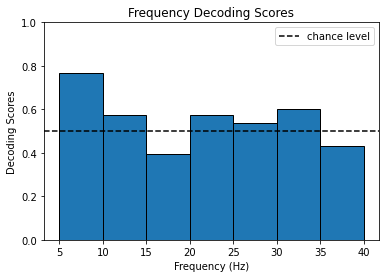

In [15]:
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
# plt.axhline(len(epochs['feet']) / len(epochs), color='k', linestyle='--',
#             label='chance level')
plt.axhline(0.5, color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

No baseline correction applied


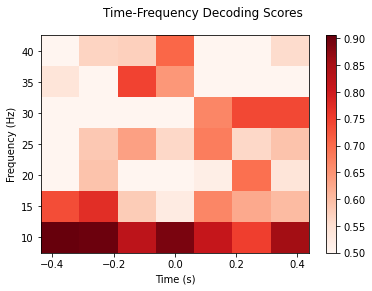

[<Figure size 432x288 with 2 Axes>]

In [14]:
# Set up time frequency object
av_tfr = AverageTFR(create_info(['freq'], 1000), tf_scores[np.newaxis, :],
                    centered_w_times, freqs[1:], 1)

chance = .5  # set chance level to white in the plot
av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)


In [132]:
# data 2
print(tf_scores)

print(freq_scores)

[[0.40915033 0.3912854  0.39389978 0.39684096]
 [0.65152505 0.541939   0.49444444 0.54379085]
 [0.41775599 0.40708061 0.33877996 0.38845316]
 [0.45392157 0.55904139 0.44934641 0.37265795]
 [0.50849673 0.36633987 0.4711329  0.41187364]
 [0.5167756  0.4627451  0.53061002 0.366122  ]
 [0.5711329  0.46503268 0.65       0.55087146]]
[0.37603486 0.49586057 0.37864924 0.41938998 0.32538126 0.46557734
 0.49150327]


Text(0.5, 1.0, 'Frequency Decoding Scores')

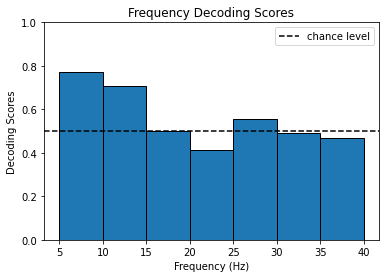

In [12]:
plt.bar(freqs[:-1], freq_scores, width=np.diff(freqs)[0],
        align='edge', edgecolor='black')
plt.xticks(freqs)
plt.ylim([0, 1])
# plt.axhline(len(epochs['feet']) / len(epochs), color='k', linestyle='--',
#             label='chance level')
plt.axhline(0.5, color='k', linestyle='--',
            label='chance level')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Decoding Scores')
plt.title('Frequency Decoding Scores')

No baseline correction applied


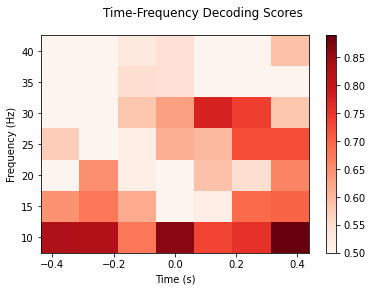

[<Figure size 432x288 with 2 Axes>]

In [13]:
# Set up time frequency object
av_tfr = AverageTFR(create_info(['freq'], 1000), tf_scores[np.newaxis, :],
                    centered_w_times, freqs[1:], 1)
chance = .5  # set chance level to white in the plot
av_tfr.plot([0], vmin=chance, title="Time-Frequency Decoding Scores",
            cmap=plt.cm.Reds)

In [ ]:
# 2
# old script for decoding scores

# freq_scores = np.zeros((n_freqs - 1,))
# tf_scores = np.zeros((n_freqs - 1, n_windows))
#
# for freq, (fmin, fmax) in enumerate(freq_ranges):
#     w_size = n_cycles / ((fmax + fmin) / 2.)
#
#     resp_lock_lm_B1_epochs_filtered = resp_lock_lm_B1_epochs.copy().filter(l_freq=fmin, h_freq=fmax, skip_by_annotation='edge')
#     resp_lock_rm_B1_epochs_filtered = resp_lock_rm_B1_epochs.copy().filter(l_freq=fmin, h_freq=fmax, skip_by_annotation='edge')
#
#     y = np.array(
#         [0 for _ in resp_lock_lm_B1_epochs_filtered.events[:, 2]] +
#         [1 for _ in resp_lock_rm_B1_epochs_filtered.events[:, 2]]
#     )
#     X = np.append(
#         resp_lock_lm_B1_epochs_filtered.copy().get_data(),
#         resp_lock_rm_B1_epochs_filtered.copy().get_data(),
#         axis=0
#     )
#     print(X.shape)
#
#     freq_scores[freq] = np.mean(
#         cross_val_score(
#             estimator=clf,
#             X=X,
#             y=y,
#             scoring='roc_auc',
#             cv=cv,
#             n_jobs=1
#         ),
#         axis=0
#     )
#
#     if np.isnan(freq_scores[freq]):
#         sad_beep()
#         raise ValueError(f'Linalg error {fmin}-{fmax} Hz')
#
#     print('_____________________________________________')
#     print(freq_scores[freq])
#     print('_____________________________________________')
#
#     for t, w_time in enumerate(centered_w_times):
#         w_tmin = w_time - w_size / 2.
#         w_tmax = w_time + w_size / 2.
#
#         if w_tmin < tmin:
#             w_tmin = tmin
#         if w_tmax > tmax:
#             w_tmax = tmax
#         assert w_tmin < w_tmax
#
#         X = np.append(
#             resp_lock_lm_B1_epochs_filtered.copy().crop(w_tmin, w_tmax).get_data(),
#             resp_lock_rm_B1_epochs_filtered.copy().crop(w_tmin, w_tmax).get_data(),
#             axis=0
#         )
#
#         tf_scores[freq, t] = np.mean(
#             cross_val_score(
#                 estimator=clf,
#                 X=X,
#                 y=y,
#                 scoring='roc_auc',
#                 cv=cv,
#                 n_jobs=1
#             ),
#             axis=0
#         )
#
#         if np.isnan(tf_scores[freq, t]):
#             sad_beep()
#             raise ValueError(f'Linalg error {fmin}-{fmax} Hz, {w_tmin}-{w_tmax} ms')
#
#         print('_____________________________________________')
#         print(tf_scores[freq, t])
#         print('_____________________________________________')
#
# happy_beep()